### LoRA Based Fine-Tuning of Qwen 2.5 for Time-Series Forecasting 

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import transformers
import os
import random
import h5py
import pandas as pd
import time
import importlib
from pprint import pprint
import torch 
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu' 

In [5]:
random_state = 28
np.random.seed(random_state)

In [30]:
train_split = 0.8

In [7]:
file_path = "data/lotka_volterra_data.h5"  # Change this to the correct path

In [8]:
with h5py.File(file_path, "r") as f:
    # Print the dataset keys
    print("Keys in HDF5 file:", list(f.keys()))
    time_data, traj_data = f[list(f.keys())[0]][:], f[list(f.keys())[-1]][:]

Keys in HDF5 file: ['time', 'trajectories']


##### Need to find which axes are of prey (0) and predator (1)

In [31]:
data_prey, data_pred = traj_data[:, :, 0], traj_data[:, :, -1]

print(time_data.shape, data_prey.shape, data_pred.shape)

data_prey_train, data_prey_test = data_prey[:int(train_split * len(data_prey))], data_prey[int(train_split * len(data_prey)):]  
data_pred_train, data_pred_test = data_pred[:int(train_split * len(data_pred))], data_pred[int(train_split * len(data_pred)):]

np.random.shuffle(data_prey_train)
np.random.shuffle(data_pred_train), 


print('------ train-test-shape ------')
print(data_prey_train.shape, data_prey_test.shape)
print(data_pred_train.shape, data_pred_test.shape)

(100,) (1000, 100) (1000, 100)
------ train-test-shape ------
(800, 100) (200, 100)
(800, 100) (200, 100)


#### Evolution

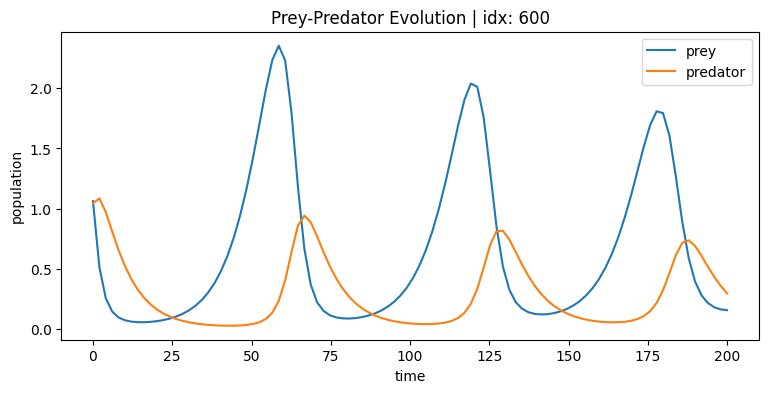

In [10]:
rn = random.randint(0, len(data_prey))

fig = plt.figure(figsize=(9, 4))

plt.plot(time_data, data_prey[rn], label = 'prey')
plt.plot(time_data, data_pred[rn], label = 'predator')
plt.xlabel('time')
plt.ylabel('population')

plt.legend()
plt.title(f'Prey-Predator Evolution | idx: {rn}')
plt.show()

#### Qwen 2.5 (Untrained) - Zero Shot Forecasting

Qwen's Interfacing

```
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "Qwen/Qwen2.5-0.5B-Instruct"

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(model_name)

prompt = "Give me a short introduction to large language model."
messages = [
    {"role": "system", "content": "You are Qwen, created by Alibaba Cloud. You are a helpful assistant."},
    {"role": "user", "content": prompt}
]
text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
)
model_inputs = tokenizer([text], return_tensors="pt").to(model.device)

generated_ids = model.generate(
    **model_inputs,
    max_new_tokens=512
)
generated_ids = [
    output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
]

response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

```

In [11]:
from utils.qwen import load_qwen

ft = time.time()
model, tokenizer = load_qwen()
lt = time.time()

print('time-taken: ', (lt - ft)/60, 'mins') 

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


time-taken:  0.2334551970163981 mins


In [12]:
model

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=896, out_features=896, bias=True)
          (k_proj): Linear(in_features=896, out_features=128, bias=True)
          (v_proj): Linear(in_features=896, out_features=128, bias=True)
          (o_proj): Linear(in_features=896, out_features=896, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((896,), eps=1e-06)
    (rotary_emb): Qwen2RotaryEmbe

##### LLMTIME preprocessing scheme (tokenize time-series data for Qwen instruct model)

In [13]:
import utils.preprocess
importlib.reload(utils.preprocess)
from utils.preprocess import ts_encoding, ts_decoding

In [14]:
check_rn = random.randint(0, len(data_prey))

In [15]:
tokenized_prey, offset_prey, scale_prey = ts_encoding(data_prey[check_rn], model_type="gpt", precision=3, alpha=0.99, beta=0.3)
tokenized_pred, offset_prey, scale_prey = ts_encoding(data_pred[check_rn], model_type="gpt", precision=3, alpha=0.99, beta=0.3)

# print(tokenized_prey.shape, tokenized_pred.shape)
print('----------GPT-Encoding-------------')
print('Input: ', data_prey)
print('Tokenized: ', tokenized_prey)

print()
print()

tokenized_prey, offset_prey, scale_prey = ts_encoding(data_prey[check_rn], model_type="llama", precision=3, alpha=0.99, beta=0.3)
tokenized_pred, offset_prey, scale_prey = ts_encoding(data_pred[check_rn], model_type="llama", precision=3, alpha=0.99, beta=0.3)

# print(tokenized_prey.shape, tokenized_pred.shape)
print('----------LLAMA-Encoding-------------')
print('Input: ', data_prey)
print('Tokenized: ', tokenized_prey)

Offset:  -0.19025743 Scale-Factor:  2.0098839
Offset:  -0.01747723 Scale-Factor:  1.0883054
----------GPT-Encoding-------------
Input:  [[1.0360398  0.46140563 0.18964638 ... 0.5017382  0.6175964  0.7559635 ]
 [0.91268444 0.5248095  0.36764902 ... 2.5897996  2.28217    1.8935541 ]
 [0.81169707 0.7060653  0.6307734  ... 0.27738366 0.20293328 0.16651598]
 ...
 [1.1288372  1.025194   0.9859951  ... 0.48976815 0.6844779  0.9849731 ]
 [1.1316459  0.80084616 0.6483697  ... 0.70776564 0.7266514  0.7947279 ]
 [1.0202591  0.76560074 0.6272315  ... 1.0364599  1.1292115  1.2237015 ]]
Tokenized:  0 . 5 2 3, 0 . 4 0 4, 0 . 3 2 5, 0 . 2 7 7, 0 . 2 5 0, 0 . 2 3 8, 0 . 2 3 6, 0 . 2 4 2, 0 . 2 5 5, 0 . 2 7 7, 0 . 3 0 7, 0 . 3 4 9, 0 . 4 0 3, 0 . 4 7 1, 0 . 5 5 5, 0 . 6 5 3, 0 . 7 6 1, 0 . 8 6 8, 0 . 9 5 5, 0 . 9 9 3, 0 . 9 5 6, 0 . 8 4 1, 0 . 6 7 9, 0 . 5 2 1, 0 . 4 0 1, 0 . 3 2 2, 0 . 2 7 5, 0 . 2 4 9, 0 . 2 3 7, 0 . 2 3 5, 0 . 2 4 1, 0 . 2 5 5, 0 . 2 7 6, 0 . 3 0 7, 0 . 3 4 9, 0 . 4 0 3, 0 . 4 7 2, 0

### Shouldn't we jointly train prey and predator population <-- Since they are correlated 

##### Seperated Inferencing (we seperately infer the prey and predator population time-series | This messes up the scaling) --- maybe error in encoding
One way to combine is ``` prey_t, pred_t ; prey_t+1, pred_t+1 ...``` 

In [16]:
forecast_length = 25
max_tokens = 512

In [30]:
def create_forecast_prompt(encoded_series, forecast_length=10, name='prey'):

    prompt = f"""<|im_start|>user
    I have a time series representing {name} populations. Each timestep is separated by commas.

    Time series data: {encoded_series}

    Predict exactly {forecast_length} timesteps, following the same pattern and formatting.
    Ensure the output consists of exactly {forecast_length} values, comma-separated, without any additional text or explanation.
    Stop generating after {forecast_length} steps.

    Output format example:
    [value1, value2, ..., value{forecast_length}]

    Strictly follow this format and do not generate more or fewer than {forecast_length} values.
    <|im_end|>
    <|im_start|>assistant
    """
    
    return prompt

# Generate forecasts
def generate_forecast(encoded_series, forecast_length=10, max_new_tokens=100):

    prompt = create_forecast_prompt(encoded_series, forecast_length)
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    
    # Set parameters for more deterministic generation
    outputs = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        temperature=0.1,  # Low temperature for more deterministic output
        do_sample=True,
        pad_token_id=tokenizer.eos_token_id
    )
    
    # Extract only the newly generated tokens
    generated_text = tokenizer.decode(outputs[0][inputs.input_ids.shape[1]:], skip_special_tokens=True)
    return generated_text.strip()

In [31]:
prey_prompt = create_forecast_prompt(tokenized_prey, forecast_length=forecast_length, name='prey')
pprint(prey_prompt)
print()
print()
pred_prompt = create_forecast_prompt(tokenized_pred, forecast_length=forecast_length, name='predator')
pprint(pred_prompt)

('<|im_start|>user\n'
 '    I have a time series representing prey populations. Each timestep is '
 'separated by commas.\n'
 '\n'
 '    Time series data: 0.300, 0.256, 0.237, 0.234, 0.243, 0.261, 0.289, '
 '0.326, 0.372, 0.428, 0.494, 0.569, 0.652, 0.741, 0.830, 0.913, 0.979, 1.013, '
 '1.000, 0.927, 0.798, 0.641, 0.495, 0.386, 0.318, 0.280, 0.263, 0.262, 0.272, '
 '0.292, 0.321, 0.360, 0.408, 0.464, 0.530, 0.603, 0.681, 0.762, 0.838, 0.902, '
 '0.943, 0.946, 0.902, 0.809, 0.683, 0.552, 0.442, 0.365, 0.318, 0.293, 0.285, '
 '0.290, 0.306, 0.331, 0.365, 0.408, 0.460, 0.519, 0.585, 0.656, 0.728, 0.796, '
 '0.853, 0.889, 0.894, 0.858, 0.782, 0.677, 0.563, 0.464, 0.391, 0.343, 0.317, '
 '0.308, 0.311, 0.325, 0.348, 0.381, 0.421, 0.470, 0.526, 0.587, 0.652, 0.717, '
 '0.776, 0.823, 0.850, 0.847, 0.810, 0.739, 0.647, 0.550, 0.464, 0.400, 0.358, '
 '0.334, 0.326, 0.331, 0.345, 0.369\n'
 '\n'
 '    Predict exactly 25 timesteps, following the same pattern and '
 'formatting.\n'
 '    Ensure th

In [32]:
ft = time.time()
prey_response = generate_forecast(prey_prompt, forecast_length=forecast_length, max_new_tokens=max_tokens)
prey_decoded_response = ts_decoding(prey_response, model_type="gpt", precision=3, offset=offset_prey, scale_factor=scale_prey)[:forecast_length]
lt = time.time()

print(prey_decoded_response)
print('LEN: ', len(prey_decoded_response), ' time-taken: ', (lt - ft) / 60)

print()

ft = time.time()
pred_response = generate_forecast(pred_prompt, forecast_length=forecast_length, max_new_tokens=max_tokens)
pred_decoded_response = ts_decoding(pred_response, model_type="gpt", precision=3, offset=offset_prey, scale_factor=scale_prey)[:forecast_length]
lt = time.time()

print(pred_decoded_response)
print('LEN: ', len(pred_decoded_response), ' time-taken: ', (lt - ft) / 60)

[0.496 0.303 0.219 0.206 0.246 0.325 0.448 0.611 0.813 1.059 1.349 1.679
 2.044 2.436 2.827 3.192 3.482 3.632 3.575 3.254 2.686 1.996 1.354 0.875
 0.576]
LEN:  25  time-taken:  2.1364352226257326

[0.989 0.765 0.611 0.51  0.448 0.417 0.426 0.466 0.545 0.677 0.883 1.182
 1.596 2.115 2.664 3.078 3.126 2.774 2.22  1.688 1.253 0.927 0.699 0.54
 0.43 ]
LEN:  25  time-taken:  1.8298371275266012


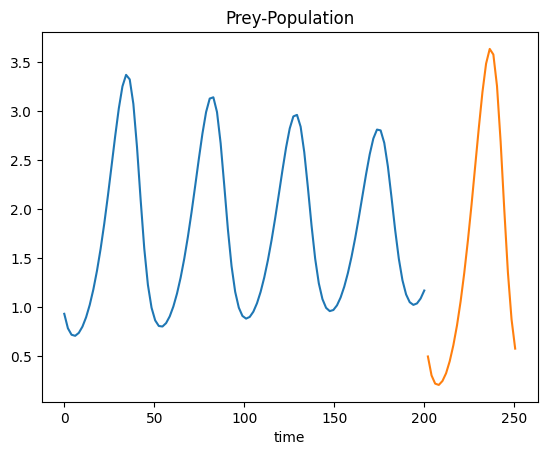

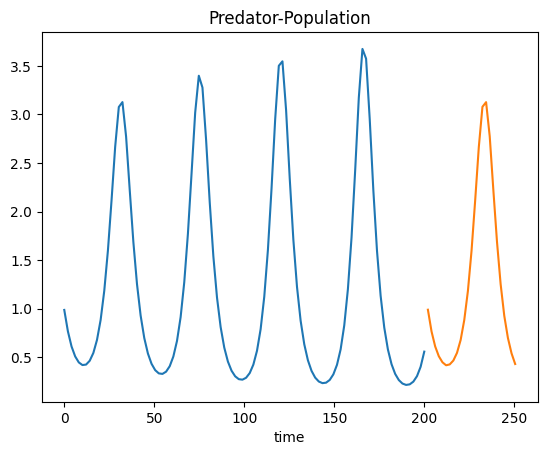

In [34]:
diff = abs(time_data[0] - time_data[1])

time_test_data = []
tmp = time_data[-1]
for _ in range(len(prey_decoded_response)):
    tmp += diff
    time_test_data.append(tmp)

plt.plot(time_data, data_prey[check_rn].tolist())
plt.plot(time_test_data, prey_decoded_response)
plt.title('Prey-Population')
plt.xlabel('time')
plt.show()

print()

plt.plot(time_data, data_pred[check_rn].tolist())
plt.plot(time_test_data, pred_decoded_response)
plt.title('Predator-Population')
plt.xlabel('time')
plt.show()

##### LoRA pre-training (we low-rank train the query and value projection matrices - retrain the attention networks)

In [32]:
import utils.lora
importlib.reload(utils.lora)
from utils.lora import LoRALinear
from utils.preprocess import process_sequences
from torch.utils.data import TensorDataset, DataLoader

In [33]:
print(data_prey_train.shape, data_prey_test.shape)

(800, 100) (200, 100)


In [34]:
batch_size = 4
learning_rate = 1e-5
lora_rank = 4
max_ctx_length = 512

In [35]:
model

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): LoRALinear(
            (original_linear): Linear(in_features=896, out_features=896, bias=True)
          )
          (k_proj): Linear(in_features=896, out_features=128, bias=True)
          (v_proj): LoRALinear(
            (original_linear): Linear(in_features=896, out_features=128, bias=True)
          )
          (o_proj): Linear(in_features=896, out_features=896, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm(

In [37]:
# Actually apply LoRA to the model:
for layer in model.model.layers:
    ### replacing attention layers with trainable layers (r * in_dim) + (out_dim * r)
    layer.self_attn.q_proj = LoRALinear(layer.self_attn.q_proj, r=lora_rank) 
    layer.self_attn.v_proj = LoRALinear(layer.self_attn.v_proj, r=lora_rank)

# Process the data into sequences of text
# train_texts, val_texts = load_and_preprocess("data/lotka_volterra_data.h5")

AssertionError: 

In [28]:
train_tokenized = ts_encoding(data_prey_train, model_type="llama", precision=3, alpha=0.99, beta=0.3)
test_tokenized = ts_encoding(data_prey_test, model_type="llama", precision=3, alpha=0.99, beta=0.3)

train_input_ids = process_sequences(train_tokenized, max_ctx_length, stride=max_ctx_length // 2)
val_input_ids = process_sequences(test_tokenized, max_ctx_length, stride=max_ctx_length)

train_dataset = TensorDataset(train_input_ids)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

Offset:  -3.284067 Scale-Factor:  10.234629


TypeError: unsupported format string passed to numpy.ndarray.__format__

In [ ]:
optimizer = torch.optim.Adam((p for p in model.parameters() if p.requires_grad), lr=learning_rate)

In [ ]:
# # Prepare components with Accelerator
# accelerator = Accelerator()
# model, optimizer, train_loader = accelerator.prepare(model, optimizer, train_loader)

model.train()
steps = 0

while steps < 10000:
    progress_bar = tqdm(train_loader, desc=f"Steps {steps}")
    for (batch,) in progress_bar:
        
        optimizer.zero_grad()
        outputs = model(batch, labels=batch)
        
        loss = outputs.loss
        loss.backward()
        
        optimizer.step()
        
        steps += 1

        progress_bar.set_postfix(loss=loss.item())
        if steps > 10000:
            break

model.eval()